In [1]:
from functions import *

# Find stability

### Test on one contour

x-location difference CoM-CoB = -2.71 px


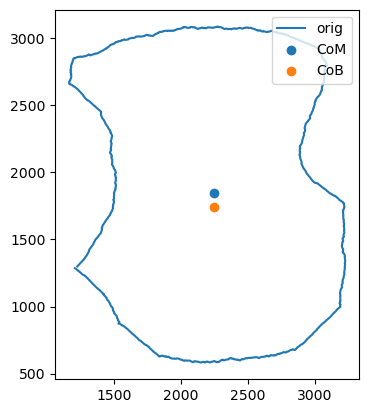

In [ ]:
plt.figure()
contour = np.genfromtxt(contoursPATH[15],dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

plt.plot(contour[:,0],contour[:,1],label='orig')



com,cob = hydrostasy(contour)

plt.scatter(com.x,com.y,label='CoM')
plt.scatter(cob.x,cob.y,label='CoB')
print(f'x-location difference CoM-CoB = {com.x-cob.x:.2f} px')

plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
plt.show()

### Check rotations of contour

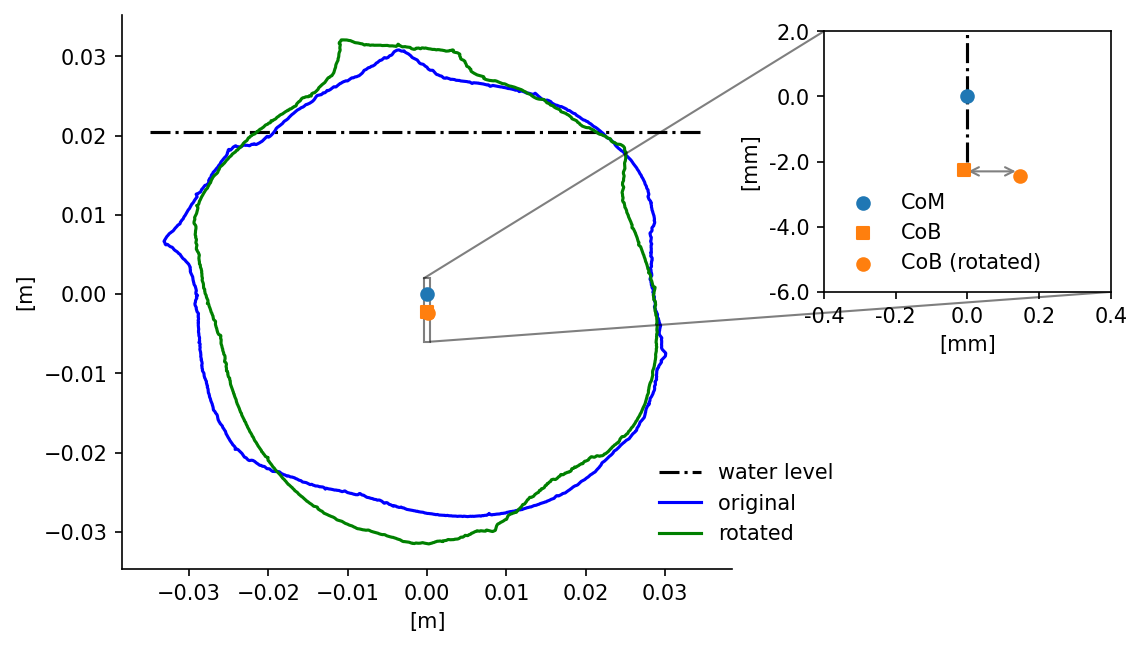

SUM Stability index = 208.5 degrees
DIFF Stability index = 80.5 degrees
NEW Stability index = 29.61282150738213


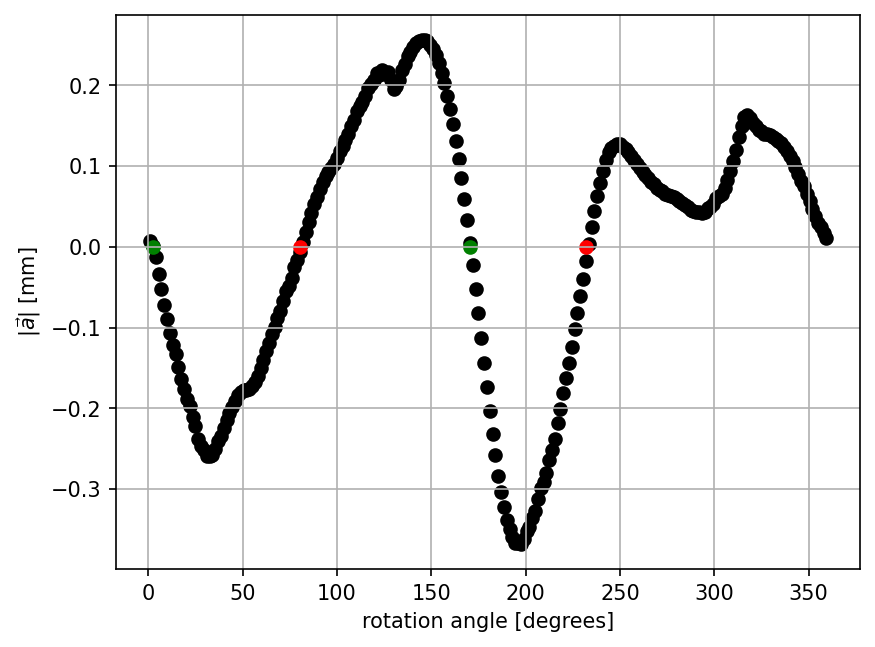

In [59]:
area_px = 1694812 # done with fiji
area_m = np.pi*0.0405**2
calibration = np.sqrt(area_px/area_m) #px/m

frame = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0115.csv'
contour = np.genfromtxt(frame,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = (contour[:,1] - com.y)

_,ax = plt.subplots(dpi=150)
ax.hlines(findWL(contour),-0.035,0.035,colors='k',linestyles='-.',label='water level')
rotAngle = 60
com,cob = hydrostasy(contour,densityRatio=917/1005)
ax.scatter(0,0,marker='o',color='tab:blue',zorder=100)
ax.scatter(cob.x,cob.y,color='tab:orange',marker='s',zorder=100)
initialCoB = [cob.x,cob.y]
rotatedCont = rotate(contour,[com.x,com.y],rotAngle)
ax.plot(contour[:,0],contour[:,1],color='blue',label='original ')
ax.plot(rotatedCont[:,0],rotatedCont[:,1],color='green',label='rotated')
del com

com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
ax.scatter(cob.x,cob.y,color='tab:orange',zorder=100)
ax.set(xlabel ='[m]',ylabel='[m]')
ax.legend(bbox_to_anchor=(.85, 0.225),frameon=False)
ax.set_aspect('equal')
# inset axes....
x1, x2, y1, y2 = -0.0003, +0.0003, -0.006, +0.001 # subregion of the original image
axins = ax.inset_axes(
    [1.15, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2))
axins.scatter(0,0,marker='o',color='tab:blue',zorder=1,label='CoM')
axins.scatter(initialCoB[0],initialCoB[1],label='CoB',color='tab:orange',marker='s',zorder=100)
axins.scatter(cob.x,cob.y,label='CoB (rotated)',color='tab:orange',zorder=100)
# axins.arrow(initialCoB[0],-15e-4,cob.x,0,width=1e-4,head_length=2e-5,length_includes_head=False,color='grey')
# axins.arrow(cob.x,-15e-4,-cob.x+initialCoB[0],0,width=1e-4,head_length=2e-5,length_includes_head=False,color='grey')
axins.annotate(text='', xy=(cob.x,-23e-4), xytext=(initialCoB[0],-23e-4), arrowprops=dict(arrowstyle='<->',color='Grey'))
axins.vlines(0,-0.002, +0.002,colors='k',linestyles='-.',zorder=0)

axins.set_yticks(axins.get_yticks().tolist())
axins.set_yticklabels(np.array(axins.get_yticks().tolist())*1000)
axins.set_xticks(axins.get_xticks().tolist())
axins.set_xticklabels([f'{i:.1f}' for i in np.array(axins.get_xticks().tolist())*1000])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axins.set_xlabel('[mm]')
axins.set_ylabel('[mm]')
axins.legend(frameon=False)
ax.indicate_inset_zoom(axins, edgecolor="black")
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/rotationStability.pdf',format='pdf',bbox_inches='tight')
plt.show()

plt.figure(dpi=150)
angleStep = 1.5
stability = np.zeros((int(360/angleStep),2))

for i,angle in enumerate(np.arange(1,360,angleStep)):
    com,_ = hydrostasy(contour,densityRatio=917/1005)
    rotatedCont = rotate(contour,[com.x,com.y],angle)
    del com
    com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
    stability[i] = angle, (com.x-cob.x)*1000

plt.scatter(stability[:,0],stability[:,1],c='k')
zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
index_zc = stability[zero_crossings,0]
# plt.plot(stability[:,0],np.gradient(stability[:,1]))
unstablePointsAngles = []
for i in zero_crossings:
    if np.gradient(stability[:,1])[i]<0:
        plt.scatter(stability[i,0],0,c='green')
    else:
        plt.scatter(stability[i,0],0,c='red')
        unstablePointsAngles.append(stability[i,0])

# SUM is how distant are the two closest unstable equilibria
print(f'SUM Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')
# DIFF is how distant is the closest unstable equilibrium 
print(f'DIFF Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])} degrees')
print(f'NEW Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))}')

plt.ylabel(r'$|\vec{a}|$ [mm]')
plt.xlabel('rotation angle [degrees]')
plt.grid()
# plt.title(f'Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1])):.2f}')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/stabilityIndex.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Apply to all contours

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


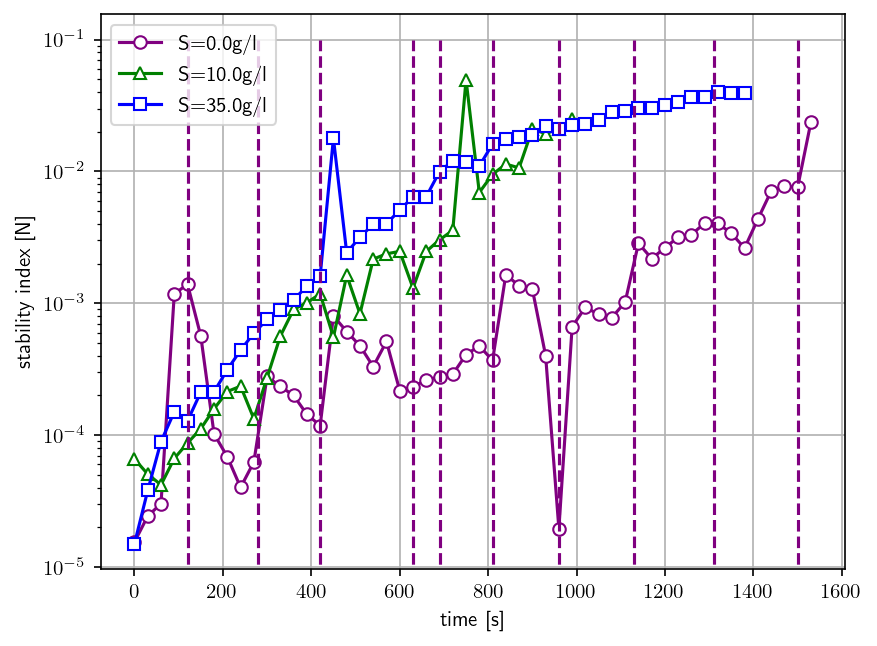

In [ ]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-20/1st','2023-09-26/1st','2023-10-03/1st']

plt.rcParams['text.usetex'] = True
plt.figure(dpi=150)

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')

    radii = []
    xs = []
    ys = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour /= conversion
        area = PolyArea(contour[:,1],contour[:,0]) # m2
        buoyancy = area*917*g # N/m
        
        angleStep = 1.5
        stability = np.zeros((int(360/angleStep),2))

        for i,angle in enumerate(np.arange(1,360,angleStep)):
            com,_ = hydrostasy(contour) ### CHANGE SALTY OR FRESH
            rotatedCont = rotate(contour,[com.x,com.y],angle)
            del com
            com,cob = hydrostasy(rotatedCont)  ### CHANGE SALTY OR FRESH
            stability[i] = angle, com.x-cob.x

        zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
        index_zc = stability[zero_crossings,0]
        unstablePointsAngles = []
        for i in zero_crossings:
            if np.gradient(stability[:,1])[i]>0:
                unstablePointsAngles.append(stability[i,0])

        # print(f'Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')
        kwargs_ = [['o','purple'],
                  ['^','green'],
                  ['s','blue']]
        
        # if it==0:
        #     plt.scatter(30*it,min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))/buoyancy,marker=kwargs_[ic][0],
        #                 c=kwargs_[ic][1],label=f'S={info[1,0]}g/l',
        #                 )
        # else:
        #     plt.scatter(30*it,min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))/buoyancy,marker=kwargs_[ic][0],
        #                 c=kwargs_[ic][1],
        #                 )
        xs.append(30*it)
        ys.append(min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))/buoyancy)
    if exp_sal==35.: ys[15]=np.nan
    plt.plot(xs,ys,marker=kwargs_[ic][0],
                        c=kwargs_[ic][1],mec=kwargs_[ic][1],mfc='white',
                        label=f'S={info[1,0]}g/l')
        
# draw rotation lines
for t in [12,28,42,63,69,81,96,113,131,150]: # rotation times of 09/20/1st
   plt.vlines(t*10,0,1e-1,colors='purple',linestyles='dashed')
#for t in []: # rotation times of 09/20/1st
#    plt.vlines(t*10,25,375,colors='blue')

plt.ylabel('stability index [N]',)
plt.xlabel('time [s]',)
plt.grid()
plt.gca().tick_params(axis='x', )
plt.gca().tick_params(axis='y', )
plt.legend()
#plt.ylim(0,4000)
plt.yscale('log')
# plt.title('Rotations make the ice more stable.\n Salinity stratifies water, which makes stability increase over time.')
plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/stability.eps',format='eps',bbox_inches='tight')
plt.show()
